In [1]:
import os, sys, math, time

from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(0,"/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/LibFolder")
from Lib_GeneralFunctions import *
from Lib_GeneralSignalProcNAnalysis import *
from Lib_ProfilePlotting import *
from Lib_ProfileProcessing import *


#=================== Plotting style ===================
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
plt.style.use('seaborn-whitegrid')

from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

#definition of colormap
from palettable.scientific.sequential import LaJolla_20
cmap = LaJolla_20.mpl_colormap
plt.register_cmap(cmap=cmap)
plt.set_cmap('LaJolla_20')

plt.rcParams['image.cmap'] = 'LaJolla_20'


In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
def FontSizeControlFreak(SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE):
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Timestamp variable
start_time = time.time()

In [4]:
# Save into a class the 
class SSCreference:
    def __init__(self, filename, coordinates, RefSource="SEM2DPACK"):
        
        line = pd.read_csv(filename.format("slip"), header=None)
        self.Time = line[0]
        self.Slip = line[1]
        
        line = pd.read_csv(filename.format("sr"), header=None)
        self.SlipRate = line[1]
        
        self.Coord = coordinates #Only used for labels and printing
        self.RefSource = RefSource
    #end __init__
    
    # Default object printing information
    def __repr__(self):
        return "The reference object was generated from: {} and the receiver is located at {}".format(self.RefSource, self.Coord)
    #end __repr__
    
    def __str__(self):
        return "The reference object was generated from: {} and the receiver is located at {}".format(self.RefSource, self.Coord)
    #end __str__
    
    def PlotReference(self, ax, SlipSlipRate, filtering=True, **kwargs):
        
        if SlipSlipRate=="Slip":
            if(filtering):
                ax.plot(self.Time, Butterworth(self.Slip, **kwargs), label = "", c = "k", ls = "--", zorder=1)
            else:
                ax.plot(self.Time, self.Slip, label = "", c = "k", ls = "--", zorder=1)
        elif SlipSlipRate=="SlipRate":
            if(filtering):
                ax.plot(self.Time, Butterworth(self.SlipRate, **kwargs), label = "", c = "k", ls = "--", zorder=1)
            else:
                ax.plot(self.Time, self.SlipRate, label = "", c = "k", ls = "--", zorder=1)
            
        return ax

In [5]:
path = "/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/"

# Reference saved into a list of objects
RefList = [SSCreference(path + "Reference/sem2dpack/sem2d-{}-1.txt", "2km"),
           SSCreference(path + "Reference/sem2dpack/sem2d-{}-2.txt", "4km"),
           SSCreference(path + "Reference/sem2dpack/sem2d-{}-3.txt", "6km"),
           SSCreference(path + "Reference/sem2dpack/sem2d-{}-4.txt", "8km"),
          ]

In [6]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/P4/"
Data = pd.read_csv(Path+"SlipAtReceiver.txt",sep="\t")
Data.columns

Index(['Time', 'ele', 'q', 'Slip', 'SlipRate', 'x', 'y', 'FaultX', 'FaultY'], dtype='object')

In [7]:
def FilterDataForFloatEquality(Data, Column, Value, Tolerance = 1e-1):
    return Data.loc[(abs(Data[Column]-Value).lt(Tolerance))]

# Separate per faultY parameter

# Comparing the same location at different QP

In [11]:
# Live Plotting of a underwritting file
class SlipDataObject:
    def __init__(self, filename):
        self.FileName = filename
        self.Data = pd.read_csv(filename,sep="\t")
    #end __init__
    
    # Default object printing information
    def __repr__(self):
        return "File loaded: {}".format(self.FileName)
    #end __repr__
    
    def __str__(self):
        return "File loaded: {}".format(self.FileName)
    #end __str__
    
    def FilterDataForFloatEquality(self, Data, Column, Value, Tolerance = 1e-1):
        return Data.loc[(abs(self.Data[Column]-Value).lt(Tolerance))]

    def reload(self):
        self.Data = pd.read_csv(self.FileName, sep="\t")
    
    def getDataSubDomain(self, FaultX, FaultXValue, FaultY, FaultYValue, q):
        FxData = self.FilterDataForFloatEquality(self.Data, FaultX, FaultXValue)
        FyData = self.FilterDataForFloatEquality(FxData, FaultY, FaultYValue)
        return FyData.loc[FyData["q"].eq(q)]


def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.set_xlim(-0.5,4)
        ax.set_ylim(-0.5,10)
        
    Lines = fig.axes[-1].get_lines()[-5:]
    
    legend2 = fig.axes[-1].legend(Lines, ['Reference', '8km','6km', '4km', '2km'], loc=1)
    fig.axes[-1].add_artist(legend2)

def GenericFigAxis():
    fig = plt.figure(constrained_layout=True, figsize=[12,4])
    gs = GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    
    return fig, [ax1, ax2]

In [12]:
def Plotting(fig, axis, DataObj,FilteringSpecs):
    DataObj.reload()
    FilteredDataframe = DataObj.getDataSubDomain(**FilteringSpecs)

    x_values = FilteredDataframe.Time
    y_values = FilteredDataframe.Slip
    yPrime_values = FilteredDataframe.SlipRate

    AA=0
    axis[0].plot(x_values, np.cumsum(yPrime_values)*(x_values.iloc[1]-x_values.iloc[0]))
    #axis[0].plot(x_values, np.cumsum(y_values))
    #axis[0].plot(x_values, y_values)
    axis[0].set_xlabel('Time = {}'.format(FilteredDataframe.Time.iloc[-1]))
    axis[0].set_ylabel('Slip')
    axis[0].set_title('Slip')

    axis[1].plot(x_values, yPrime_values)
    axis[1].set_ylabel('Slip rate')
    axis[1].set_title('Slip rate')
    axis[1].set_xlabel('Time = {}'.format(FilteredDataframe.Time.iloc[-1]))
    
    fig.gca().relim()
    fig.gca().autoscale_view()


# P6

$S = \Delta V\  dt + \frac{\delta}{\mu}(c-f(t)(-\sigma^{avg}_{yy}))$

$dS = S - S_{t-1}$

$\gamma=\frac{dS}{2\delta} P_n(\phi/2\delta)$

$S_{q}\ =S_{t-1} + dS$

$\dot{S}_{q}=dS\ /\ dt$

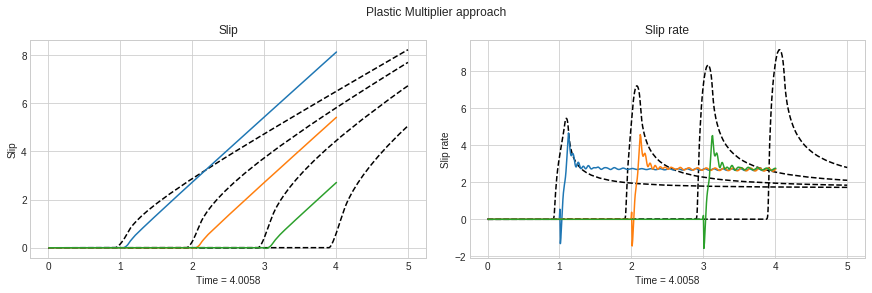

In [13]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/P6/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                 "FaultY":"FaultY", "FaultYValue":100, 
                 "q":0}
plt.ion()
[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plotting(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plotting(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plotting(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

# P1

$\dot{S} = \Delta V - \frac{\delta}{\mu}(\frac{f(t)-f(t-1)}{dt})(-\sigma^{avg}_{yy})$

$dS = \dot{S}\ dt $

$\gamma=\frac{dS}{2\delta} P_n(\phi/2\delta)$

$S_{q}\ += S$

$\dot{S}_{q}=dS\ /\ dt$

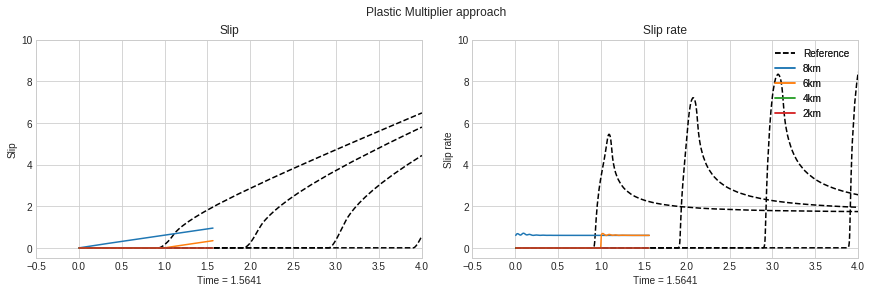

In [14]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/P1/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}
plt.ion()
[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plotting(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plotting(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plotting(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plotting(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
format_axes(fig)

# P9

$S = \Delta U + \frac{\delta}{\mu}(c-f(t)(-\sigma^{avg}_{yy}))$

$dS = S - S_{t-1}$

$\gamma=\frac{dS}{2\delta} P_n(\phi/2\delta)$

$S_{q}\ = S$

$\dot{S}_{q}=dS\ /\ dt$

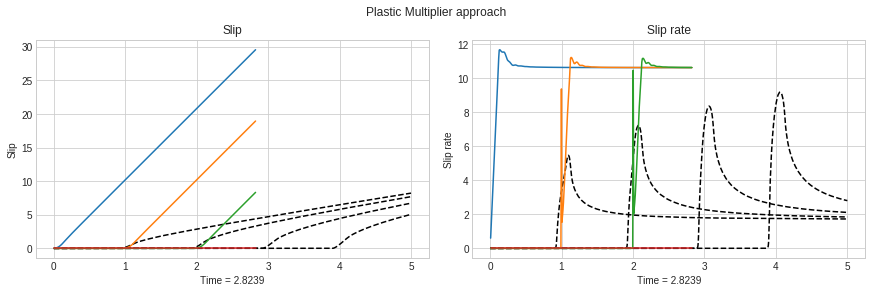

In [15]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/P9/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}
plt.ion()
[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plotting(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plotting(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plotting(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plotting(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

# Looks like I didnt save the code when I commented out the slip updating scheme. Of course it was not calculating correctly the accumulation

god...
I start again and the plotting function is changed to not scroll up again

In [16]:
def Plottings(fig, axis, DataObj,FilteringSpecs):
    DataObj.reload()
    FilteredDataframe = DataObj.getDataSubDomain(**FilteringSpecs)

    x_values = FilteredDataframe.Time
    y_values = FilteredDataframe.Slip
    yPrime_values = FilteredDataframe.SlipRate

    AA=0
    #axis[0].plot(x_values, np.cumsum(yPrime_values)*(x_values.iloc[1]-x_values.iloc[0]))
    axis[0].plot(x_values, y_values)
    axis[0].set_xlabel('Time = {}'.format(FilteredDataframe.Time.iloc[-1]))
    axis[0].set_ylabel('Slip')
    axis[0].set_title('Slip')

    axis[1].plot(x_values, yPrime_values)
    axis[1].set_ylabel('Slip rate')
    axis[1].set_title('Slip rate')
    axis[1].set_xlabel('Time = {}'.format(FilteredDataframe.Time.iloc[-1]))
    
    fig.gca().relim()
    fig.gca().autoscale_view()

# P2

$S = \Delta U + \frac{\delta}{\mu}(c-f(t)(-\sigma^{avg}_{yy}))$

$dS = S - S_{t-1}$

$\gamma=\frac{dS}{2\delta} P_n(\phi/2\delta)$

$S_{q}\ += dS$

$\dot{S}_{q}=dS\ /\ dt$

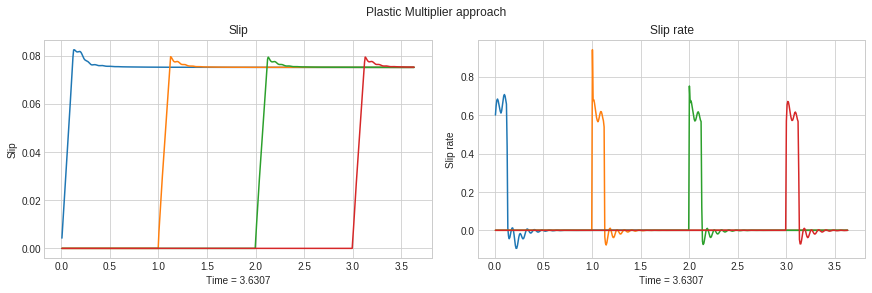

In [17]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/P2/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}
plt.ion()
#[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
#[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

# ^After that change, now the slip is consistent with the slip rate

# P3

$S = \Delta U + \frac{\delta}{\mu}(c-f(t)(-\sigma^{avg}_{yy}))$

$dS = S - S_{t-1}$

$\gamma=\frac{S}{2\delta} P_n(\phi/2\delta)$

$S_{q}\ += dS$

$\dot{S}_{q}=dS\ /\ dt$

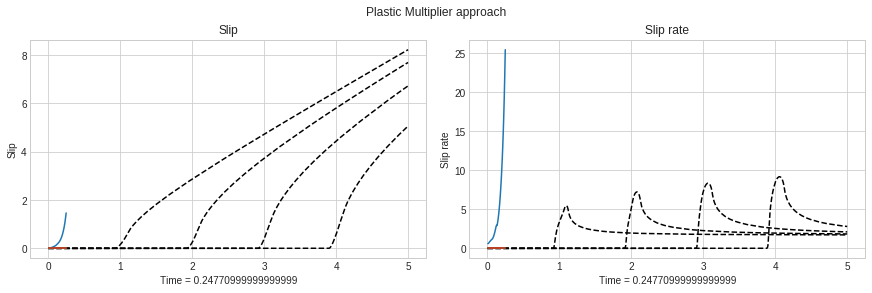

In [18]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/P3/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}
plt.ion()
[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

# P4

$\dot{S} = \Delta V - \frac{\delta}{\mu}(\frac{f(t)-f(t-1)}{dt})(-\sigma^{avg}_{yy})$

$dS = \dot{S}\ dt$

$\gamma=\frac{dS}{2\delta} P_n(\phi/2\delta)$

$S_{q}\ += dS$

$\dot{S}_{q}=dS\ /\ dt$

TypeError: unsupported operand type(s) for -: 'str' and 'int'

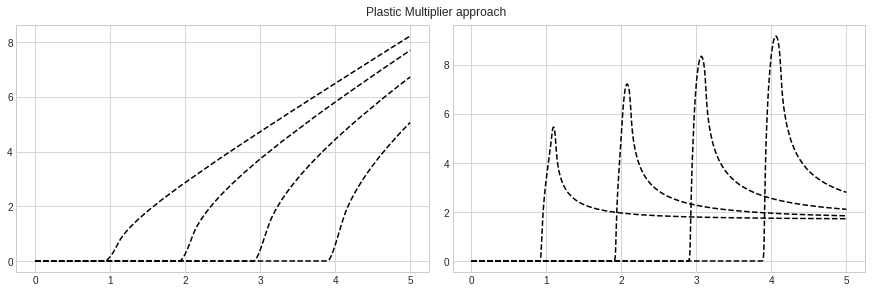

In [19]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/P4/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}
plt.ion()
[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

#Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

# P10

$S = \Delta U + \frac{\delta}{\mu}\ (f_{static}\sigma_{n}-f(t)\sigma^{avg}_{yy}) $

$dS = S - S_{t-1}$

$\gamma=\frac{S}{2\delta} P_n(\phi/2\delta)$

$S_{q}\ += dS$

$\dot{S}_{q}=dS\ /\ dt$

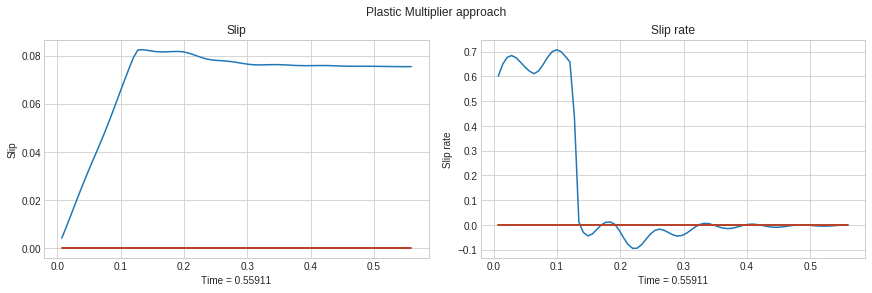

In [28]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/P10/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}
plt.ion()
#[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
#[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

# P11

$\dot{S} = \Delta V - \frac{\delta}{\mu}\ \frac{(f(t)-f(t-dt))}{dt}(-\sigma^{avg}_{yy}) $

$dS = \dot{S}dt$

$\gamma=\frac{dS}{2\delta} P_n(\phi/2\delta)$

--------------

$\sigma_{xy} -= 2\mu\ \gamma$

$S_{q}\ += dS$

$\dot{S}_{q}=dS\ /\ dt$

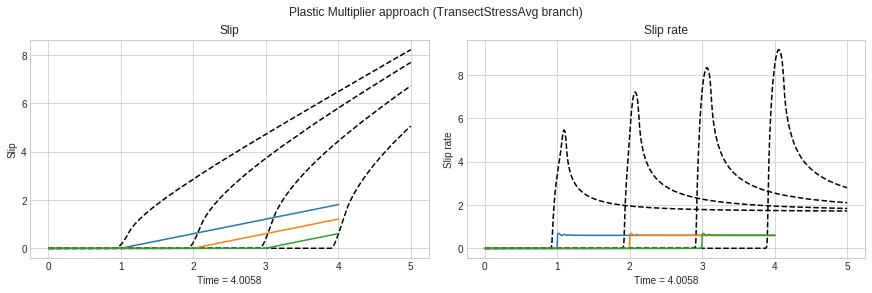

In [29]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/P11/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach (TransectStressAvg branch)")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}
plt.ion()
[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

#Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

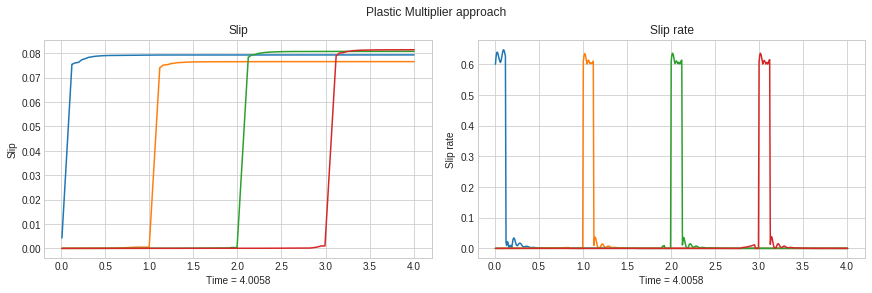

In [30]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/P13/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}
plt.ion()
#[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
#[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

# P11

$\dot{S} = \Delta V - \frac{\delta}{\mu}\ \frac{(f(t)-f(t-dt))}{dt}(-\sigma^{avg}_{yy}) $

$dS = \dot{S}dt$

$\gamma=\frac{dS}{2\delta} P_n(\phi/2\delta)$

$S_{q}\ += dS$

$\dot{S}_{q}=dS\ /\ dt$

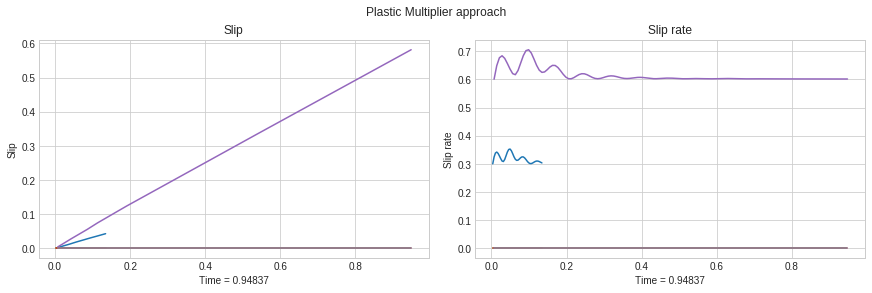

In [31]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/TransectVersion50m/"
DataObj = SlipDataObject(Path + "SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":50, 
                  "q":0}
plt.ion()
#[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
#[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)


Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/TransectVersion/"
DataObj = SlipDataObject(Path + "SlipAtReceiver.txt")


FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

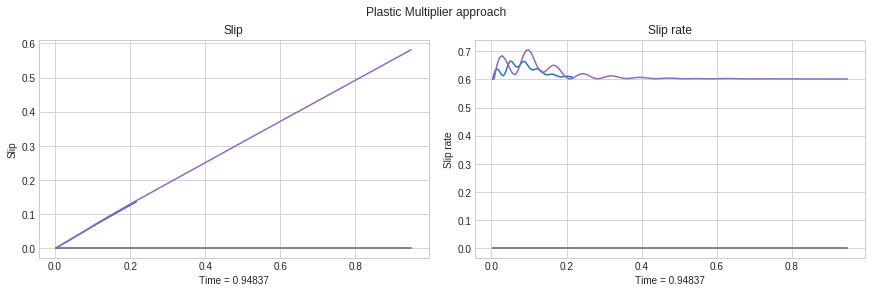

In [32]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/TransectVersion50mdelta100/"
DataObj = SlipDataObject(Path + "SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}
plt.ion()
#[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
#[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)


Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/TransectVersion/"
DataObj = SlipDataObject(Path + "SlipAtReceiver.txt")


FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

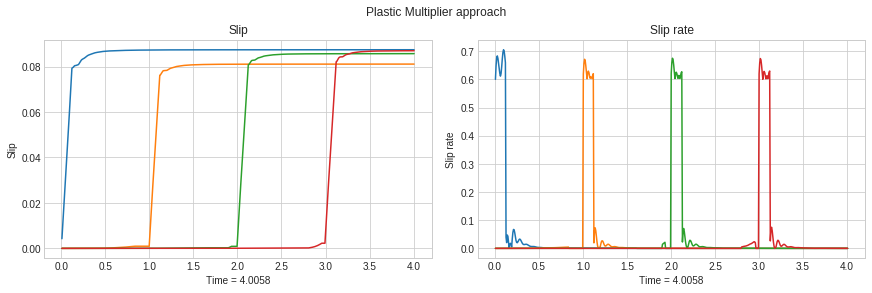

In [33]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/PlasticMultiplier/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}
plt.ion()
#[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
#[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

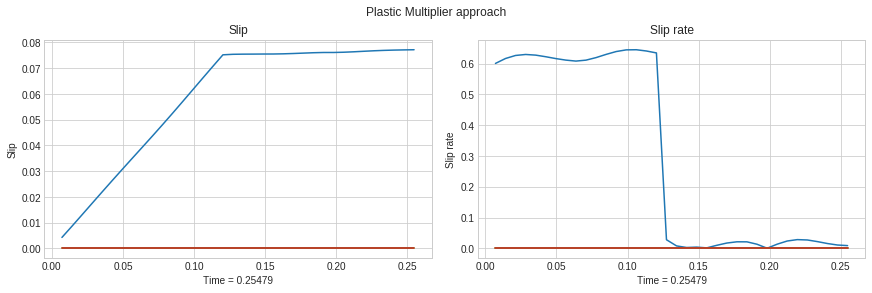

In [34]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/AvgStressPM/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":0, 
                  "q":0}
plt.ion()
#[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
#[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

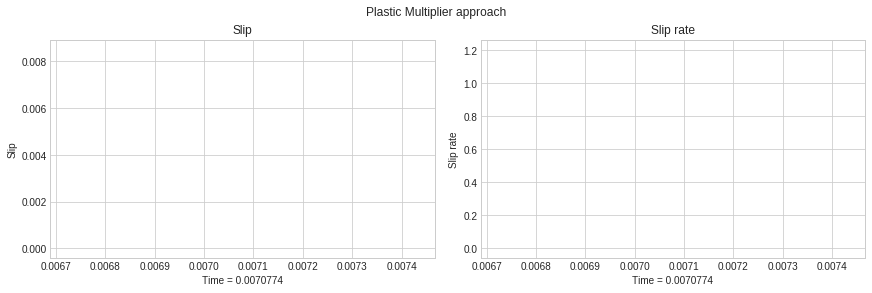

In [85]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/AvgStressTrial2/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":0, 
                  "q":0}
plt.ion()
#[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
#[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

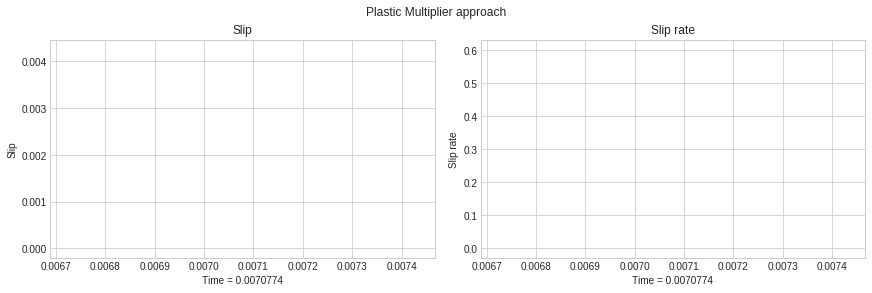

In [97]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/Runs/AvgStressTrial2/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":0, 
                  "q":0}
plt.ion()
#[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
#[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)

# SCP connected Slip slip rate 

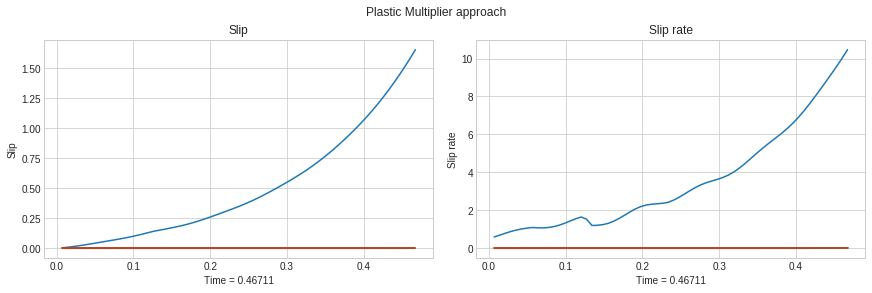

In [124]:
Path = "/home/nico/Documents/TEAR/Codes_TEAR/se2dr/WolfelResults/"
DataObj = SlipDataObject(Path+"SlipAtReceiver.txt")

fig, axis = GenericFigAxis()
fig.suptitle("Plastic Multiplier approach")

FilteringSpecs = {"FaultX":"FaultX", "FaultXValue":2000,
                  "FaultY":"FaultY", "FaultYValue":100, 
                  "q":0}
plt.ion()
#[item.PlotReference(axis[0], "Slip", filtering=True) for item in RefList]
#[item.PlotReference(axis[1], "SlipRate", filtering=True) for item in RefList]

Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":0})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":2000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":4000})
Plottings(fig, axis, DataObj, {**FilteringSpecs, "FaultXValue":6000})
#format_axes(fig)